In [1]:
import os
import ssl
import socket
import hashlib
import requests
import json

import datetime as dt
import OpenSSL.crypto as crypto

import certifi
from urllib.parse import quote as url_friendly
from urllib.parse import urlparse


# Detect Man-In-The-Middle Attack in your HTTPS traffic
+ This notebook is inspired from this [site](https://checkmyhttps.net/) and corresponding [Firefox extension](https://addons.mozilla.org/en-US/firefox/addon/checkmyhttps/)

+ The general idea is to get a certificate's digest from a safe computer and network, store it as reference, and update it from time to time.

+ In a suspicious environment, typically where the computer and/or network is potentially unsecure (e.g. corporate setting, internet café, etc), use the browser to check a website's fingerprint. **DO NOT** stop at the green <span style="color: green;">https:</span>//a-web-site.com symbol that suggests everything is fine. If the digest you read is different from the reference, it means the **certificate was fabricated** and appears valid only because a root certificate was planted in the computer you use by a malevolent administrator.

+ In this case your are very likely experiencing a [Man-In-The-Middle Attack](https://en.wikipedia.org/wiki/Man-in-the-middle_attack). Your passwords are probably read and stored by the attacker. **DANGER !**

+ These attacks are very frequent particularly from proxies...


## 1 - Requests
+ Based on the certificates available on the machine and certifi package.
+ Not reliable if machine was configured by third party (e.g. corporate, internet café).

In [2]:
login = 'adam.smith'
pwd = 'freetrade'
proxy_addr = 'my-proxy.com'
proxy_port = 8080

proxies = {
    'http': 'http://{}:{}@{}:{}'.format(login, url_friendly(pwd), proxy_addr, proxy_port),
    'https': 'https://{}:{}@{}:{}'.format(login, url_friendly(pwd), proxy_addr, proxy_port)
}
proxies = {}

def check_SSL_A(url, proxies={}, verbose=False):
    u = urlparse(url)
    if u.scheme=='http':
        if verbose: print(url + ' is not SSL encrypted')
        return False
    else:
        try:
            r = requests.get(url, verify=certifi.where(), proxies=proxies)
            if verbose: print(url + ' SSL certificate is valid')
            return True
        except requests.exceptions.SSLError:
            if verbose: print (url + ' SSL certificate is NOT valid')
            return False

            
li_url = ['https://www.google.com',
          'https://www.github.com',
          'https://www.gitlab.com',
          'https://www.linkedin.com',
          'https://www.facebook.com',
          'https://www.amazon.com',
          'https://www.amazon.fr',
          'https://www.apple.com',
          'https://www.apple.fr',
          'https://www.yahoo.com',
          'https://mabanque.bnpparibas/',
          'https://particuliers.societegenerale.fr',
          'http://example.com',
          'https://self-signed.badssl.com',
         ]
res = {}
for url in li_url:
    res[url] = check_SSL_A(url, proxies=proxies, verbose=True)

res

https://www.google.com SSL certificate is valid
https://www.github.com SSL certificate is valid
https://www.gitlab.com SSL certificate is valid
https://www.linkedin.com SSL certificate is valid
https://www.facebook.com SSL certificate is valid
https://www.amazon.com SSL certificate is valid
https://www.amazon.fr SSL certificate is valid
https://www.apple.com SSL certificate is valid
https://www.apple.fr SSL certificate is valid
https://www.yahoo.com SSL certificate is valid
https://mabanque.bnpparibas/ SSL certificate is valid
https://particuliers.societegenerale.fr SSL certificate is valid
http://example.com is not SSL encrypted
https://self-signed.badssl.com SSL certificate is NOT valid


{'http://example.com': False,
 'https://mabanque.bnpparibas/': True,
 'https://particuliers.societegenerale.fr': True,
 'https://self-signed.badssl.com': False,
 'https://www.amazon.com': True,
 'https://www.amazon.fr': True,
 'https://www.apple.com': True,
 'https://www.apple.fr': True,
 'https://www.facebook.com': True,
 'https://www.github.com': True,
 'https://www.gitlab.com': True,
 'https://www.google.com': True,
 'https://www.linkedin.com': True,
 'https://www.yahoo.com': True}

## 2 - SSL
### <span style="color: red;">IMPORTANT</span>: Run this cell from a safe computer and without proxy
+ Manually retrieve remote certificate
+ Extract digest using pyopenssl
+ Manually compute digest
+ Check both digests are the same

In [3]:

def get_certificate_data(pem_cert):
    """
    X509 certificate extraction
    Cf. http://pyopenssl.sourceforge.net/pyOpenSSL.html/openssl-x509.html
    """
    ocert = crypto.load_certificate(crypto.FILETYPE_PEM, pem_cert)
    d = {}
    
    # issuer
    a = ocert.get_issuer()
    d['issuer'] = a.get_components()

    # subject
    a = ocert.get_subject()
    d['subject'] = a.get_components()

    # serial number
    a = ocert.get_serial_number()
    d['serial number'] = a

    # version
    a = ocert.get_version()
    d['version'] = a

    # notBefore
    a = ocert.get_notBefore().decode('utf-8')
    a = dt.datetime.strptime(a, '%Y%m%d%H%M%SZ')
    d['notBefore'] = a

    #  notAfter
    a = ocert.get_notAfter().decode('utf-8')
    a = dt.datetime.strptime(a, '%Y%m%d%H%M%SZ')
    d['notAfter'] = a

    # expiry
    a = ocert.has_expired()
    d['expiry'] = a

    # digest
    a = ocert.digest('md5')
    d['md5'] = a
    a = ocert.digest('sha1')
    d['sha1'] = a

    # pubkey
    a = ocert.get_pubkey()
    a = a.to_cryptography_key()
    d['pubkey'] = a.public_numbers()

    return d

def overview(url, d):
    print('\n' + '*'*60 + '\n', url)
    li_key = ['X509', 'human_cert', 'pem_cert', 'hash']
    for k in li_key:
        if k in d:
            print('\n', k)
            print(d[k])
            
    
def check_SSL_B(url, verbose=False):
    u = urlparse(url)
    addr = u.netloc
    
    if u.scheme=='http':
        if verbose: print('*'*60 + '\n' + url + '\n\nNo SSL encryption\n')
        return {}
        
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(1)
    wrappedSocket = ssl.wrap_socket(sock, cert_reqs=ssl.CERT_OPTIONAL, ca_certs=certifi.where())

    try:
        wrappedSocket.connect((addr, 443))
        der_cert_bin = wrappedSocket.getpeercert(binary_form=True)
        hr_cert = wrappedSocket.getpeercert(binary_form=False)
        pem_cert = ssl.DER_cert_to_PEM_cert(wrappedSocket.getpeercert(True))
        wrappedSocket.close()
        
        fingerprint_md5 = hashlib.md5(der_cert_bin).hexdigest()
        fingerprint_sha1 = hashlib.sha1(der_cert_bin).hexdigest()
        fingerprint_sha256 = hashlib.sha256(der_cert_bin).hexdigest()
        
        if verbose:
            print('*'*60 + '\n' + url + '\n\n' + pem_cert + '\n' + 'sha1: \n' + fingerprint_sha1 + '\n')
        
        d = {'der_cert_bin': der_cert_bin,
             'human_cert': hr_cert,
             'pem_cert': pem_cert,
             'hash': {'sha1': fingerprint_sha1,
                      'sha256': fingerprint_sha256,
                      'md5': fingerprint_md5,
                     },
             'X509': get_certificate_data(pem_cert)
             }
        return d
    
    except:
        if verbose: print('*'*60 + '\n' + url + '\n\nInvalid SSL Certificate\n')
        return {}

res = {}
for url in li_url:
    print(url)
    res[url] = check_SSL_B(url, verbose=False)


https://www.google.com
https://www.github.com
https://www.gitlab.com
https://www.linkedin.com
https://www.facebook.com
https://www.amazon.com
https://www.amazon.fr
https://www.apple.com
https://www.apple.fr
https://www.yahoo.com
https://mabanque.bnpparibas/
https://particuliers.societegenerale.fr
http://example.com
https://self-signed.badssl.com


## 2.1 - Main certificate information retrieved

In [4]:
# for url, d in res_B.items():
#     overview(url, d)

url = 'https://www.github.com'
overview(url, res[url])



************************************************************
 https://www.github.com

 X509
{'issuer': [(b'C', b'US'), (b'O', b'DigiCert Inc'), (b'OU', b'www.digicert.com'), (b'CN', b'DigiCert SHA2 Extended Validation Server CA')], 'subject': [(b'businessCategory', b'Private Organization'), (b'jurisdictionC', b'US'), (b'jurisdictionST', b'Delaware'), (b'serialNumber', b'5157550'), (b'street', b'88 Colin P Kelly, Jr Street'), (b'postalCode', b'94107'), (b'C', b'US'), (b'ST', b'California'), (b'L', b'San Francisco'), (b'O', b'GitHub, Inc.'), (b'CN', b'github.com')], 'serial number': 15938810608981134066197160231674485287, 'version': 2, 'notBefore': datetime.datetime(2016, 3, 10, 0, 0), 'notAfter': datetime.datetime(2018, 5, 17, 12, 0), 'expiry': False, 'md5': b'B8:90:FA:BE:8B:B6:36:25:89:9E:1E:00:49:81:47:97', 'sha1': b'D7:9F:07:61:10:B3:92:93:E3:49:AC:89:84:5B:03:80:C1:9E:2F:8B', 'pubkey': <RSAPublicNumbers(e=65537, n=29228291586411801150687864404306523745724345591150737242344515708146

## 2.2 - Show reference certificates digests (SHA)

In [5]:
sha1 = {}
for k, v in res.items():
    if 'hash' in v:
        sha1[k] = v['hash']['sha1']

sha1

{'https://mabanque.bnpparibas/': 'b1db484bc33f4a1a853fd537f4436e58aad03691',
 'https://particuliers.societegenerale.fr': '2b0716ab17b01234cfe951b3be28eba045007068',
 'https://www.amazon.com': 'b9f0baa72ae706aae50a007b5170e0a4c471b99b',
 'https://www.amazon.fr': '3bfecdc46e276353110a9b4228f765929156fc60',
 'https://www.apple.com': '9dbad3d9eed202aac0cb1c537415f425bbb9a915',
 'https://www.apple.fr': '0ea0aab641a853ec52c34148118c7b27cc4e77c6',
 'https://www.facebook.com': '936f912bafad216fa515256e572cdc35a1451aa5',
 'https://www.github.com': 'd79f076110b39293e349ac89845b0380c19e2f8b',
 'https://www.gitlab.com': '72d5d1068bfa8db30faf3a267cf532a2a1812a28',
 'https://www.google.com': '0f7779e44b2006611a11d5da70667f2b56d6fbad',
 'https://www.linkedin.com': '3a6039e8cee4fb5887b85397898f049820bfe391',
 'https://www.yahoo.com': '413072f803ce961210e9a45d10da14b0d2d48532'}

## 3 - How to check fingerprint in browser

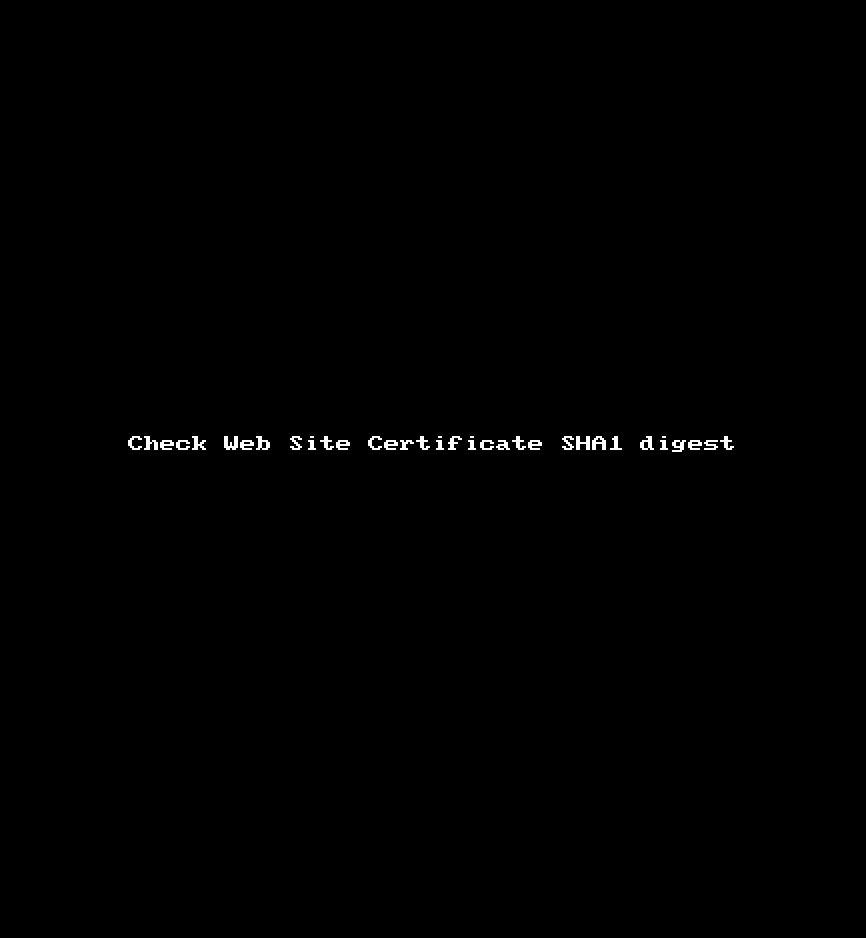

In [6]:
from IPython.display import Image
Image(os.path.join('img', 'mitm_snapshot.png'))